In [1]:
import pathlib
import pandas as pd
import eli5
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report

/Users/1150704/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Load pre-processed train and test data
data_path = pathlib.Path().cwd().parent / "data"
print(f"Logging info - Loading data from {data_path}")
train_df = pd.read_csv(f"{data_path}/train.csv", keep_default_na=False)
test_df = pd.read_csv(f"{data_path}/test.csv", keep_default_na=False)

Logging info - Loading data from /Users/1150704/Documents/mywork/zip_product_classification/data


In [3]:
# build a pipeline 
pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,3), stop_words='english', 
                                              sublinear_tf=True, max_features=50000, min_df=2)),
                     ('clf', LogisticRegression(C=1e2, n_jobs=4, solver='lbfgs', 
                                                random_state=17, verbose=0, 
                                                multi_class='multinomial',
                                                fit_intercept=True))
                    ])

In [4]:
pipeline.fit(train_df['desc'], train_df['cat0_cat1_cat2'])

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 3), stop_words='english',
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(C=100.0, multi_class='multinomial',
                                    n_jobs=4, random_state=17))])

In [5]:
pred_level_3 = pipeline.predict(test_df['desc'])

In [6]:
pred_level_3

array(['fashion|fashion-clothing|fashion-clothing-maternity',
       'fashion|fashion-clothing|fashion-clothing-pants, fashion-clothing-sleepwear',
       'fashion|fashion-clothing|fashion-clothing-jumpsuits-playsuits',
       ..., 'fashion|fashion-clothing|fashion-clothing-sleepwear',
       'hardware|hardware-tools|hardware-tools-power-tools',
       'fashion|fashion-clothing|fashion-clothing-maternity'],
      dtype=object)

In [7]:
pred_level_0 = [el.split('|')[0] for el in pred_level_3]
pred_level_1 = [el.split('|')[1] for el in pred_level_3]
pred_level_2 = [el.split('|')[2] for el in pred_level_3]

## Evaluation

In [8]:
print(classification_report(
    y_true=test_df['cat0'], 
    y_pred=pred_level_0,
    digits=4)
)

              precision    recall  f1-score   support

 electronics     0.9734    0.9686    0.9710      1211
     fashion     0.9971    0.9985    0.9978     17303
    hardware     0.9880    0.9821    0.9850      2509
        home     0.9871    0.9862    0.9866      4046

    accuracy                         0.9934     25069
   macro avg     0.9864    0.9838    0.9851     25069
weighted avg     0.9934    0.9934    0.9934     25069



In [9]:
print(classification_report(
    y_true=test_df['cat1'], 
    y_pred=pred_level_1,
    digits=4)
)

                              precision    recall  f1-score   support

      electronics-smart-home     0.9734    0.9686    0.9710      1211
                fashion-bags     0.9977    0.9966    0.9971      2615
            fashion-clothing     0.9965    0.9984    0.9975     14688
              hardware-tools     0.9880    0.9821    0.9850      2509
home-furniture, home-kitchen     0.9871    0.9862    0.9866      4046

                    accuracy                         0.9932     25069
                   macro avg     0.9886    0.9864    0.9875     25069
                weighted avg     0.9932    0.9932    0.9932     25069



In [10]:
print(classification_report(
    y_true=test_df['cat2'], 
    y_pred=pred_level_2,
    digits=4)
)

                                                                  precision    recall  f1-score   support

             electronics-smart-home-security-cameras-and-systems     0.9734    0.9686    0.9710      1211
                                 fashion-bags-laptop-tablet-bags     0.9977    0.9966    0.9971      2615
                            fashion-clothing-jumpsuits-playsuits     0.9482    0.9674    0.9577      3217
fashion-clothing-jumpsuits-playsuits, fashion-clothing-sleepwear     0.8378    0.5167    0.6392        60
     fashion-clothing-jumpsuits-playsuits, fashion-clothing-tops     0.8766    0.7584    0.8133       356
                                      fashion-clothing-maternity     0.9809    0.9764    0.9787      4746
              fashion-clothing-pants, fashion-clothing-sleepwear     0.8429    0.8365    0.8397       263
                                      fashion-clothing-sleepwear     0.9661    0.9754    0.9707      6046
                                      hardwar

In [11]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    cm = confusion_matrix(y_true, y_pred).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

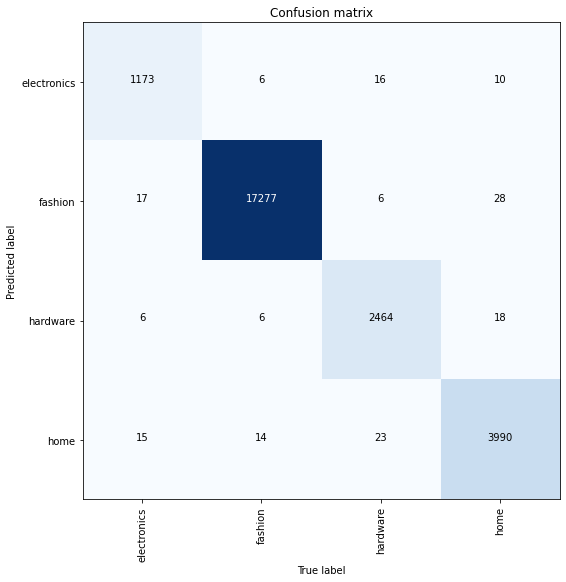

In [12]:
plot_confusion_matrix(
    y_true=test_df['cat0'],
    y_pred=pred_level_0, 
    classes=sorted(test_df['cat0'].unique()),
    figsize=(8, 8)
)

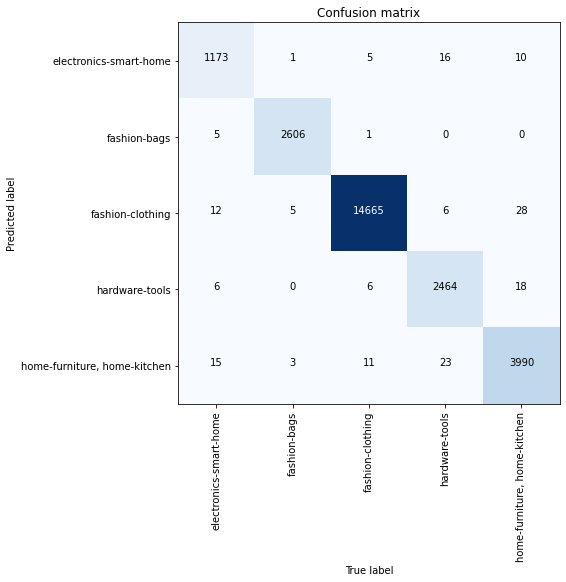

In [13]:
plot_confusion_matrix(
    y_true=test_df['cat1'],
    y_pred=pred_level_1, 
    classes=sorted(test_df['cat1'].unique()),
    figsize=(8, 8)
)

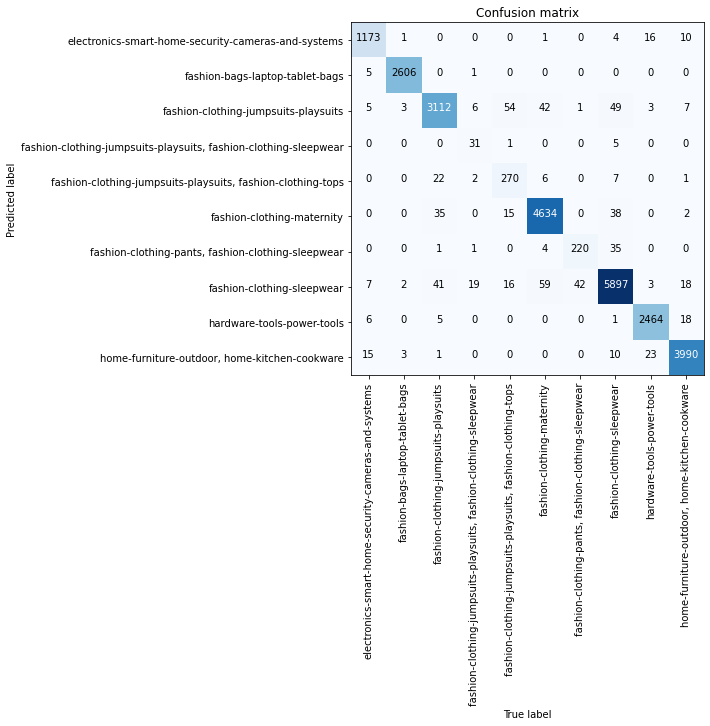

In [14]:
plot_confusion_matrix(
    y_true=test_df['cat2'],
    y_pred=pred_level_2, 
    classes=sorted(test_df['cat2'].unique()),
    figsize=(10, 10)
)

## Explainations

In [15]:
eli5.show_weights(
    estimator=pipeline.named_steps['clf'],
    vec=pipeline.named_steps['vect'])

In [18]:
# Save model
import joblib

joblib.dump(pipeline, 'baseline_model.joblib')

['baseline_model.joblib']